<a href="https://colab.research.google.com/github/doubi-xu/Political-Ideology-and-Customer-Feedback-Behaviors/blob/main/BERTforcarsdotcom_Prolific07042024_addclassweights_15STATES_ReviewLevel_cross_validation_add_MAE%26MSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [ ]:
pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import os

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

path = '/content/drive/My Drive/carsdotcom/CarsdotcomRating_Prolific_MI.xlsx'
data = pd.read_excel(path)

Mounted at /content/drive


In [ ]:
data.head()

,Qualtrics_Question,CustomerReviewRating,Feedback,Training1,Training2,Y1_modeup,Y1,Y2_modedown,Y2,Y3_moderandom,Y3,Y4_mean,Y4,Y5_EMBA_modeup,Y5
0,QID4,1.0,My salesman was great isaiah merritt.Managers ...,1,1,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0
1,QID5,1.0,Awful dealership. I would rather not drive the...,1,1,5.0,4.0,5.0,4.0,5.0,4.0,4.0,3.0,4.0,3.0
2,QID6,1.0,Trying for days now to get someone to return t...,1,1,3.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,2.0,1.0
3,QID7,1.0,My wife & I traveled to this dealership based ...,1,1,4.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0,2.0,1.0
4,QID8,1.0,After 3 attempts and 4 months to get the same ...,1,0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,NaN,NaN


In [ ]:
# Dropping rows with any missing values from the full dataset 'data'
clean_data = data.dropna(subset=['Feedback', 'Y3'])

# Displaying the shape of the original and cleaned datasets to understand how much data remains after cleaning
original_shape = data.shape
clean_shape = clean_data.shape

original_shape, clean_shape

((198442, 15), (500, 15))

In [ ]:
#Calculate Class Weights
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'Y3_moderandom' is your target variable
class_labels = np.unique(clean_data['Y3'])
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=clean_data['Y3'])

# Convert class weights to a dictionary for easy use
weight_dict = {class_label: weight for class_label, weight in zip(class_labels, class_weights)}
print(weight_dict)


{0.0: 5.882352941176471, 1.0: 1.1235955056179776, 2.0: 0.4975124378109453, 3.0: 0.684931506849315, 4.0: 2.127659574468085}


In [ ]:
# Updated tokenize_function to handle the 'Feedback' column directly
def revised_tokenize_function(examples):
    # Ensure the input is in list format for Feedback
    feedback = examples["Feedback"] if isinstance(examples["Feedback"], list) else [examples["Feedback"]]

    # Tokenize
    return tokenizer(feedback, padding="max_length", truncation=True)

# Testing the revised function with a single row of data
sample_data = {"Feedback": "Excellent service Long waiting times"}
print(revised_tokenize_function(sample_data))

{'input_ids': [[101, 6581, 2326, 2146, 3403, 2335, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Tokenize the text
tokenized_datasets = clean_data.apply(lambda x: revised_tokenize_function(x), axis=1)

In [ ]:
# Preparing dataset for BERT
class FeedbackDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx])) # Ensure labels are integers
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Splitting the data into training and validation sets
train_dataset, val_dataset = train_test_split(clean_data, test_size=0.1)

# Creating dataset objects
train_dataset = FeedbackDataset(revised_tokenize_function(train_dataset.to_dict('list')), train_dataset['Y3'].tolist())
val_dataset = FeedbackDataset(revised_tokenize_function(val_dataset.to_dict('list')), val_dataset['Y3'].tolist())

In [ ]:
# Model with weighted loss function
class BertForSequenceClassificationCustom(BertForSequenceClassification):
    # Override the method to include class weights
    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and logits
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # Define weighted loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(weight_dict.values())).cuda())
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5)
X = clean_data['Feedback']
y = clean_data['Y3']

fold_results = []
all_confusion_matrices = []
all_roc_aucs = []

In [ ]:
# Define metrics function
def compute_metrics(p):
    predictions = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


Training fold 1...



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.721500
20,1.706900
30,1.709100
40,1.588900
50,1.533100
60,1.419800
70,1.437900
80,1.386700
90,1.417700
100,1.379400


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training fold 2...



Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.704300
20,1.642500
30,1.658300
40,1.648800
50,1.595000
60,1.535900
70,1.465000
80,1.411900
90,1.373700
100,1.378200


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training fold 3...



Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.672200
20,1.677500
30,1.626900
40,1.639300
50,1.559300
60,1.518900
70,1.498300
80,1.377200
90,1.450200
100,1.347700


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training fold 4...



Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.674700
20,1.667200
30,1.646200
40,1.613200
50,1.566800
60,1.528600
70,1.463900
80,1.347900
90,1.357700
100,1.334300


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training fold 5...



Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.670200
20,1.699400
30,1.595800
40,1.606400
50,1.572800
60,1.497800
70,1.554100
80,1.365700
90,1.273000
100,1.392900


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Cross-Validation Results: {'accuracy': 0.434, 'precision': 0.3896037658831678, 'recall': 0.43400000000000005, 'f1': 0.38895605734044636, 'mae': 0.656, 'mse': 0.8559999999999999, 'roc_auc': nan}


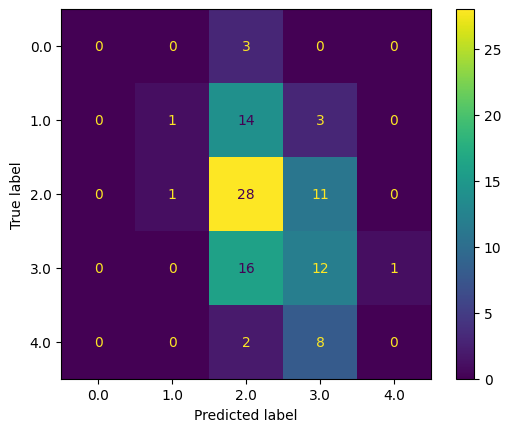

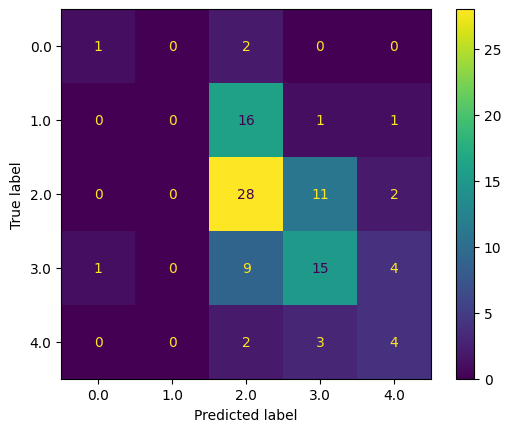

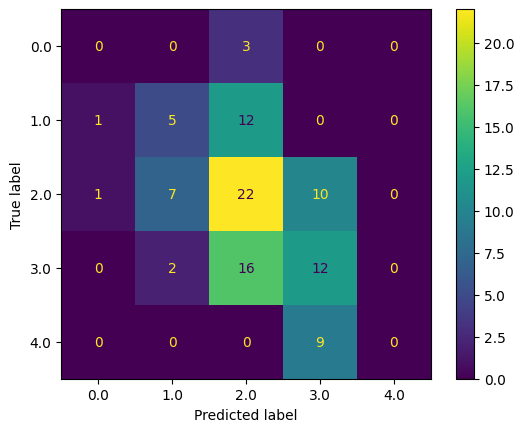

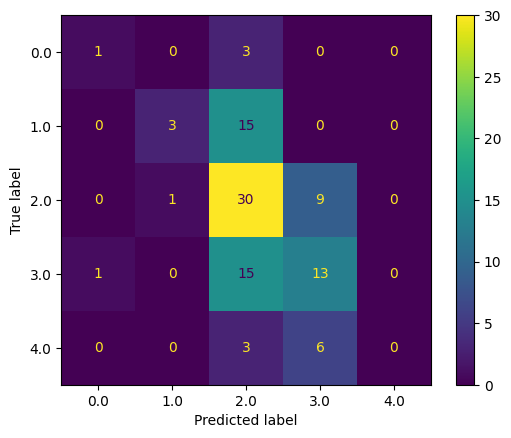

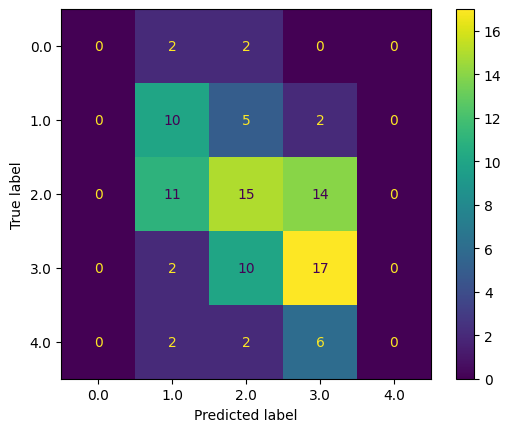

In [ ]:
# Cross-validation loop - 10092024
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nTraining fold {fold + 1}...\n")

    # Tokenize the train and validation sets
    train_texts = clean_data.iloc[train_idx]['Feedback'].tolist()
    train_labels = clean_data.iloc[train_idx]['Y3'].tolist()
    val_texts = clean_data.iloc[val_idx]['Feedback'].tolist()
    val_labels = clean_data.iloc[val_idx]['Y3'].tolist()

    train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512)
    val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=512)

    # Prepare datasets for this fold
    train_dataset = FeedbackDataset(train_encodings, train_labels)
    val_dataset = FeedbackDataset(val_encodings, val_labels)

    # Initialize model for each fold
    model = BertForSequenceClassificationCustom.from_pretrained('bert-base-uncased', num_labels=len(class_labels))

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        learning_rate=5e-5
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model for the current fold
    trainer.train()

    # Get predictions on validation data
    predictions_output = trainer.predict(val_dataset)
    predictions = predictions_output.predictions.argmax(-1)
    labels = predictions_output.label_ids

    # Calculate accuracy, precision, recall, f1 for this fold
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    # Calculate MAE and MSE
    mae = mean_absolute_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)

    # Confusion Matrix for this fold
    cm = confusion_matrix(labels, predictions)
    all_confusion_matrices.append(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()  # Display confusion matrix for each fold

    # ROC-AUC for this fold (multiclass)
    try:
        roc_auc = roc_auc_score(labels, predictions_output.predictions, multi_class='ovr')
        all_roc_aucs.append(roc_auc)
    except ValueError:
        roc_auc = "Undefined"  # Handle cases where ROC-AUC cannot be computed

    # Append fold results
    fold_results.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mae': mae,
        'mse': mse,
        'roc_auc': roc_auc
    })

# Average results across all folds
avg_results = {
    'accuracy': np.mean([result['accuracy'] for result in fold_results]),
    'precision': np.mean([result['precision'] for result in fold_results]),
    'recall': np.mean([result['recall'] for result in fold_results]),
    'f1': np.mean([result['f1'] for result in fold_results]),
    'mae': np.mean([result['mae'] for result in fold_results]),
    'mse': np.mean([result['mse'] for result in fold_results]),
    'roc_auc': np.mean([result['roc_auc'] for result in all_roc_aucs if result != "Undefined"])  # Avoid undefined ROC-AUC scores
}

# Display averaged cross-validation results
print(f"\nCross-Validation Results: {avg_results}")

In [ ]:




# Initialize your model
model = BertForSequenceClassificationCustom.from_pretrained('bert-base-uncased', num_labels=len(class_labels))


# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))},
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.661000
20,1.631300
30,1.605600
40,1.559400
50,1.503200
60,1.416700
70,1.374000
80,1.379300
90,1.308100
100,1.299900


TrainOutput(global_step=171, training_loss=1.3720774915483263, metrics={'train_runtime': 32.5595, 'train_samples_per_second': 41.463, 'train_steps_per_second': 5.252, 'total_flos': 355209492326400.0, 'train_loss': 1.3720774915483263, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Evaluate the model on the validation dataset
validation_results = trainer.evaluate(val_dataset)

# Print validation results
print(validation_results)

{'eval_loss': 1.151180624961853, 'eval_accuracy': 0.52, 'eval_runtime': 0.451, 'eval_samples_per_second': 110.872, 'eval_steps_per_second': 15.522, 'epoch': 3.0}


In [ ]:
import pandas as pd
import os

In [ ]:
# Combine all States
# Define the path to the datasets
path = '/content/drive/My Drive/carsdotcom/15States/'

# Create a list of dataset filenames
# states = ['MI', 'CA', 'TX', 'NC', 'FL1','FL2','NY','PA', 'IL', 'OH', 'GA', 'NJ', 'VA', 'WA', 'AZ', 'TN']
# states = ['MI', 'CA', 'TX']
# states = ['NC', 'FL1','FL2','NY','PA', 'IL', 'OH']
states = ['GA', 'NJ', 'VA', 'WA', 'AZ', 'TN']

filenames = [f'{state}_review.xlsx' for state in states]

# Read and concatenate datasets
# datasets = [pd.read_excel(os.path.join(path, filename)) for filename in filenames]
# states3 = pd.concat(datasets, ignore_index=True)

# datasets2 = [pd.read_excel(os.path.join(path, filename)) for filename in filenames]
# states9 = pd.concat(datasets2, ignore_index=True)

datasets3r = [pd.read_excel(os.path.join(path, filename)) for filename in filenames]
states15 = pd.concat(datasets3r, ignore_index=True)

# Display the first few rows of the combined dataset
print(states15.head())

                                          dealerLink          reviewDate  \
0  https://www.cars.com/dealers/104311/bmw-of-col...      March 12, 2020   
1  https://www.cars.com/dealers/104311/bmw-of-col...       July 24, 2013   
2  https://www.cars.com/dealers/104311/bmw-of-col...  September 25, 2021   
3  https://www.cars.com/dealers/104311/bmw-of-col...      April 28, 2022   
4  https://www.cars.com/dealers/104311/bmw-of-col...      March 24, 2014   

                  reviewUser   reviewUserFrom    reviewUserDealerInteraction  \
0                        NaN              NaN  Came in for service or repair   
1                        NaN              NaN          Shopped for a new car   
2                By Haroldbr     Columbus, GA  Came in for service or repair   
3        By William Guilford  Phenix City, AL  Came in for service or repair   
4  By Dissatisfied customer!      Columbus ga         Shopped for a used car   

                                         reviewTitle  reviewRa

In [ ]:
# Load the unseen data
#test_data_path = '/content/FL_review_117228.xlsx'
#data_to_predict = pd.read_excel(test_data_path)
# data_to_predict = states3
data_to_predict = states15

In [ ]:
# Assuming 'data_to_predict' is your DataFrame with the reviews you want to predict
# and it includes columns for 'dealerLink' and 'reviewDate' for grouping by dealer and year.

# Initialize a DataFrame to hold the aggregated results
#aggregated_results = pd.DataFrame(columns=['dealerLink', 'reviewYear', 'reviewCount'])

# Define a function to tokenize 'reviewText'
def tokenize_reviews(text):
    return tokenizer(text, padding="max_length", truncation=True)

In [ ]:
class FeedbackDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
# Initialize an empty DataFrame to store the results
# all_predictions = pd.DataFrame()
# all_predictions2 = pd.DataFrame()
all_predictions3 = pd.DataFrame()

# Process each dealer individually
for dealer, group in data_to_predict.groupby('dealerLink'):
    # Preprocess and predict labels for the current dealer's data
    group['reviewYear'] = pd.to_datetime(group['reviewDate']).dt.year

    # Prepare the review texts
    review_texts = [str(text) for text in group['reviewText'].tolist() if text is not None]

    # Tokenize the review texts
    tokenized_data = tokenize_reviews(review_texts)

    # Create the dataset
    dataset = FeedbackDataset(tokenized_data)

    # Make predictions
    predictions = trainer.predict(dataset)

    # Assign the predicted labels to the group
    group['predictedLabel'] = [int(prediction.argmax()) for prediction in predictions.predictions]

    # Append the results for the current dealer to the all_predictions DataFrame
    # all_predictions = pd.concat([all_predictions, group], ignore_index=True)
    # all_predictions2 = pd.concat([all_predictions2, group], ignore_index=True)
    all_predictions3 = pd.concat([all_predictions3, group], ignore_index=True)

    # Optionally, save intermediate results to Excel after each dealer or batch of dealers
    # all_predictions.to_excel('intermediate_predictions.xlsx', index=False)

# After processing all dealers, save the final results to an Excel file
# all_predictions.to_csv('final_predictions.csv', index=False)
# all_predictions2.to_csv('final_predictions2.csv', index=False)
all_predictions3.to_csv('final_predictions3.csv', index=False)

In [ ]:
from google.colab import files
# files.download('/content/final_predictions.csv')
# files.download('/content/final_predictions2.csv')
files.download('/content/final_predictions3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Load the three CSV files
file1 = '/content/final_predictions1.csv'
file2 = '/content/final_predictions2.csv'
file3 = '/content/final_predictions3.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

# Check if columns are the same
if list(df1.columns) == list(df2.columns) == list(df3.columns):
    print("Columns are the same in all files. Combining them...")

    # Combine the files into one DataFrame
    combined_df = pd.concat([df1, df2, df3], ignore_index=True)

    # Save the combined DataFrame to a new CSV file
    combined_df.to_csv('combined_final_predictions.csv', index=False)
    print("Files combined successfully and saved to 'combined_final_predictions.csv'.")
else:
    print("Columns are not the same in all files. Cannot combine them.")


Columns are the same in all files. Combining them...
Files combined successfully and saved to 'combined_final_predictions.csv'.


In [ ]:
files.download('/content/combined_final_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>